In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import os
import seaborn as sns
import awkward as awk

sns.set_style('whitegrid')

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica", "sans-serif"],
    "mathtext.fontset": "dejavusans",
    'font.size': 16,
    'image.cmap': 'YlGnBu',
})

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

POT = {}
bkg = {}

# POT 
POT['ND280_nu_2013'] = 1.52E20 
POT['ND280_nubar_2013'] = 1.52E20

# POT in Abe et al 2019
POT['ND280_nu_2019'] = 1.234e21
POT['ND280_nubar_2019'] = 6.29e20

POT['ND280_nu_2023'] = 19.7e20
POT['ND280_nubar_2023'] = 16.3e20

# POT Events conducted in ND280+
# 1E22 is cumulative
POT['ND280+_nu'] = 5e21 - POT['ND280_nu_2023'] 
POT['ND280+_nubar'] = 5e21 - POT['ND280_nubar_2023']


# TPC e+e- background from Abe et al 2019
bkg['ND280_nu_2019'] = 0.563
bkg['ND280_nubar_2019'] = 0.015

bkg['ND280+_nu'] = bkg['ND280_nu_2019'] * 5 / 3 * POT['ND280+_nu'] / POT['ND280_nu_2019']  # Factor of 5/3 from increase of TPC volume from 3 -> 5
bkg['ND280+_nubar'] = bkg['ND280_nubar_2019']* 5 / 3 * POT['ND280+_nubar'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2023'] = bkg['ND280_nu_2019']  * POT['ND280_nu_2023'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2023'] = bkg['ND280_nubar_2019'] * POT['ND280_nubar_2023'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2013'] = bkg['ND280_nubar_2019'] * POT['ND280_nu_2013'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2013'] = bkg['ND280_nubar_2019'] * POT['ND280_nubar_2013'] / POT['ND280_nu_2019'] 
bkg['zero'] = 0


In [2]:
# Constants
HBAR = 6.582119569e-25  # Reduced Planck constant (GeV·s)
C = 2.998e8  # Speed of light (m/s)
HBAR_C = HBAR * C  # (GeV·m)
Gf = 1.1663787e-5 # (GeV^-2)
alpha = 1/137
mass = {}
mass['e'] = 0.511e-3 # Electron mass in GeV
mass['mu'] = 0.1056583755 # Muon mass in GeV

def gamma_TMM_2body(m, mu):
    return mu**2 * m**3 / (16*np.pi)
    
def gamma_TMM_3body(m, mu, mlep=None):
    if mlep is not None:
        mask = m >= 2*mlep
        result = np.zeros_like(m)
        if np.any(mask):
            m_valid = m[mask]
            r = mlep/m_valid
            L = (2 - r**6 * 0.125) * np.arccosh(1/r) - (24 - 10 * r**2 + r**4) * 0.125 * np.sqrt(1 - 4*r**2)
            result[mask] = alpha * mu**2 * m_valid**3 * L / (48*np.pi**2)
        return result
    else:
        return result

def gamma_Total_Decay(m, mu):
    return gamma_TMM_2body(m, mu) + gamma_TMM_3body(m,mu,mass['e']) + gamma_TMM_3body(m,mu,mass['mu'])

def BR_TMM(m, mu):
    return gamma_TMM_2body(m, mu) / gamma_Total_Decay(m, mu)

def logLR(z):
    return np.absolute(z - z * 99 * np.log(1 + 1/99)) # FGD signal to bkg fraction ~1%
    
# 95% Confidence Level
def tar(cl=0.9):
    return 0.5 * stats.norm.ppf(1-cl)**2

Extract the counts

Extract weights from simulation

In [10]:
FGD_boxes = np.array([
    [0, 0, -0.375, 1.843,1.843, 0.288],
    [0, 0, 0.99, 1.843,1.843, 0.288]
]) # ND280 FGD before upgrade

FGD_boxes_upgrade = np.array([
    [0, 0, -0.375, 1.843,1.843, 0.288],
    [0, 0, 0.99, 1.843, 1.843, 0.288],
    [0, 0, -0.795, 1.920, 0.56, 1.920]
]) # ND280 FGD with super FGD

def is_points_in_boxes(points, boxes):
    points = np.asarray(points)
    boxes = np.asarray(boxes)
    centers, dimensions = boxes[:, :3], boxes[:, 3:]
    
    # Broadcasting to compare all points with all boxes
    in_bounds = np.all(
        (points[:, np.newaxis, :] >= centers - dimensions/2) & 
        (points[:, np.newaxis, :] <= centers + dimensions/2),
        axis=2
    )

    # Check if each point is in any box
    return np.any(in_bounds, axis=1)

DIF_dist = 280

def process_data(bar=False, upgrade=True):

    outfile = f'./counts{'_UPG' if upgrade else ''}_bar.txt' if bar else f'./counts{'_UPG' if upgrade else ''}.txt'

    z = []
    
    with open(outfile, 'w') as f, open('./OGTPC1.txt', 'w') as w:
        for ind, (m, mu) in enumerate(zip(m_sample, mu_sample)):
            
            path = f"TPC5_Dipole_M{m:2.2e}_mu{mu:2.2e}_example.parquet" if upgrade else f"OGTPC3_Dipole_M{m:2.2e}_mu{mu:2.2e}_example.parquet"
            file_path = f'../output_final_bar/{path}' if bar else f'../output_final/{path}'
            
            if os.path.isfile(file_path):
                try:
                    data = awk.from_parquet(file_path)
                    pts = data['vertex'][:,0]
                    weight = data['event_weight'] * BR_TMM(m, mu) * is_points_in_boxes(pts, FGD_boxes_upgrade if upgrade else FGD_boxes) # fid volume cut
                    counts = np.sum(weight[np.logical_not(np.isnan(weight))]) 
                    counts = counts if counts != 0 else 1e-300 # add padding
                    f.write(f'{m:2.10e} {mu:2.10e} {counts:2.10e}\n')
                    
                except Exception as e:
                    # If there's any error reading the file, write the parameters to the file
                    print(f"Error reading file {file_path}: {str(e)}")
                    w.write(f"{ind} {m} {mu}\n")
            else:
                w.write(f"{ind} {m} {mu}\n")
              
# process_data(bar=False, mu=1e-6, tag='prob_1E-6')
# process_data(bar=True, mu=1e-6, tag='prob_1E-6')

process_data(bar=False, upgrade=False)
process_data(bar=True, upgrade=False)
process_data(bar=False, upgrade=True)
process_data(bar=True, upgrade=True)

In [3]:

from scipy.ndimage import zoom

def create_pixel_plot(x, y, z, tar=None, scale='log', savestr=None, upgrade=False, zoom_factor=3):
    """
    Create a pixel plot with smoothed data using scipy.ndimage.zoom
    
    Parameters:
    -----------
    x, y, z : numpy arrays
        Data points and values
    tar : float or None
        Target contour level
    scale : str
        'log' or 'linear' scale
    savestr : str or None
        If provided, save contour data to this filename
    upgrade : bool
        Flag for upgrade mode
    zoom_factor : int
        Factor by which to zoom/smooth the data (higher = smoother)
    """
    # Apply log scaling if requested
    z = np.log10(z) if scale=='log' else z
    
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]
    
    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)
    
    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    
    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi
    
    # Apply zoom/smoothing to the grid
    z_grid_smooth = zoom(z_grid, zoom_factor, order=3)  # order=3 for cubic interpolation
    
    # Create new coordinate arrays for the smoothed grid
    x_smooth = np.linspace(x_unique.min(), x_unique.max(), z_grid_smooth.shape[1])
    y_smooth = np.linspace(y_unique.min(), y_unique.max(), z_grid_smooth.shape[0])
    X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the smoothed image
    im = ax.imshow(z_grid_smooth, origin='lower', 
                   extent=[x_unique.min(), x_unique.max(), 
                          y_unique.min(), y_unique.max()],
                   aspect='auto')
    
    plt.colorbar(im, label='A.U.')
    ax.set_xlabel(r'$log_{10}(m_N/MeV)$', fontsize=16)
    ax.set_ylabel(r'$log_{10}(d)$', fontsize=16)
    
    # Create x-y grid for interpolation and smooth it
    xi = np.linspace(x_unique.min(), x_unique.max(), 100 * zoom_factor)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100 * zoom_factor)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='cubic')
    
    if tar is not None:
        tar = np.log10(tar) if scale=='log' else tar
        contour_line = plt.contour(Xi, Yi, Zi, levels=[tar], 
                                 colors='white', linestyles='solid', linewidths=2)
        
        if savestr is not None:
            # Extract the contour data
            contour_data = []
            for collection in contour_line.collections:
                for path in collection.get_paths():
                    v = path.vertices
                    contour_data.append(v)
            
            # Save the contour data to a two-column .txt file
            np.savetxt('./'+savestr+'.txt', contour_data[0], delimiter=' ')
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(-7, -5)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.tight_layout()
    
    if savestr is not None:
        plt.savefig(f'fgd_{"UPG" if upgrade else ""}.pdf')
    
    plt.show()
    
    return fig, ax


x = []
y = []
z = []
zb = []

upgrade=True

with open(f'./counts{'_UPG' if upgrade else ''}.txt','r') as r:
    for line in r.readlines():
        m, u, counts = line.strip().split()
        x.append(float(m))
        y.append(float(u))
        z.append(float(counts) * POT[f'ND280+_nu'])
        
with open(f'./counts{'_UPG' if upgrade else ''}_bar.txt','r') as rb:
    for line in rb.readlines():
        _,_,counts = line.strip().split()
        zb.append(float(counts) * POT[f'ND280+_nubar'])

        
x = np.array(x)
y = np.array(y)

max_efficiency = 1.9/100 

z = np.array(z) * max_efficiency 
zb = np.array(zb) * max_efficiency

# Assume background from full analysis
z = logLR(z) 
zb = logLR(zb) 

/tmp/ipykernel_1951404/245468536.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour_line.collections:


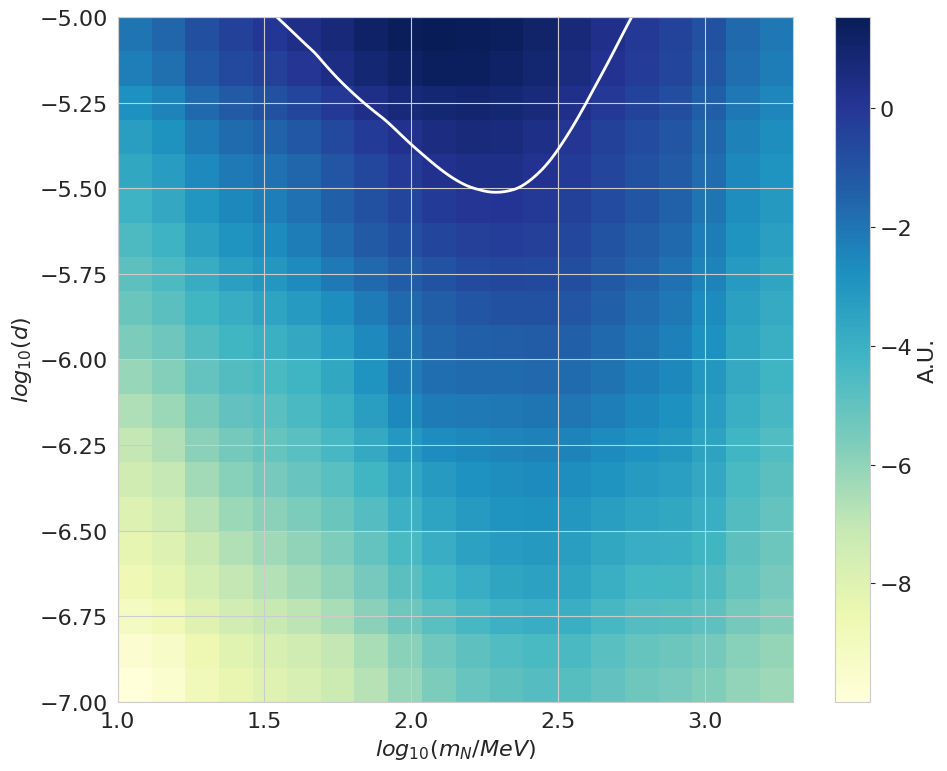

In [4]:
create_pixel_plot(np.log10(x*1000), np.log10(y), z+zb, tar(cl=0.95), scale='log', savestr=f'fgd', upgrade=upgrade, zoom_factor=2)

with open('fgd.txt','r') as r, open('sfgd.txt','w') as w:
    for line in r.readlines():
        m,mu=line.strip().split()
        w.write(f'{10**float(m):.32f} {10**float(mu):.32f}\n')

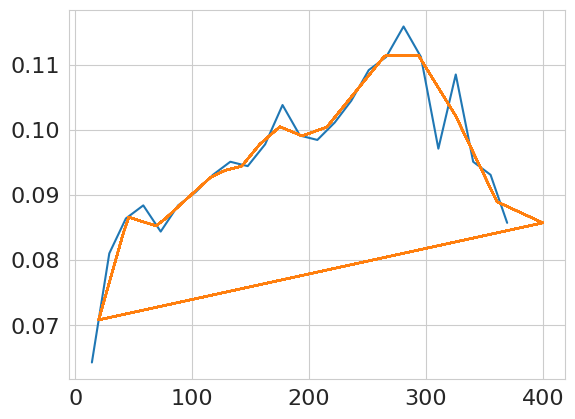

In [21]:
m_n, min_decay = np.loadtxt("kaon_decay_efficiency_data.txt", skiprows=0, usecols=(0, 1), unpack=True)
plt.plot(m_n,min_decay)
plt.plot(x*1000,min_efficiency)
plt.show()

In [5]:
def position_plot(x,y,bins,labelx,labely):
    plt.hist2d(x,y,bins=bins,norm=LogNorm())
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.tight_layout()
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",kwags=None,binnum=100,pot=1E21):
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    weights = np.array(data['event_weight'])*pot
    
    fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
    # mask out entries that are not fiducial
    fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex,axis=1)>0)
    fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex,axis=0)]))
    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],binnum),
            np.linspace(range2[0],range2[1],binnum))
    
    fig, ax = plt.subplots()
    

    position_plot(np.array(data["vertex"][dec_flag][:,0,axis1]),
        np.array(data["vertex"][dec_flag][:,0,axis2]),
        bins,"%s (m)"%slice1,"%s (m)"%slice2)

                
    plt.text( -4.5, -4.5, '$m=$%2.2e, $U_{\mu N}=$%2.2e'%(kwags['m'], kwags['U']), 
             color='black', fontsize=14, 
             bbox=dict(boxstyle="round",
                       alpha=0.7,
                       ec="black",
                       fc="white"))
    
    plt.show()

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2839219/1611536255.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.text( -4.5, -4.5, '$m=$%2.2e, $U_{\mu N}=$%2.2e'%(kwags['m'], kwags['U']),


OGTPC1_Dipole_M2.73e-02_Umu1.00e-07_example.parquet


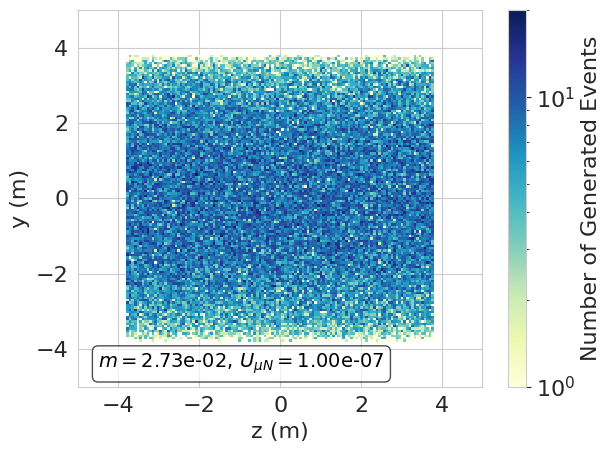

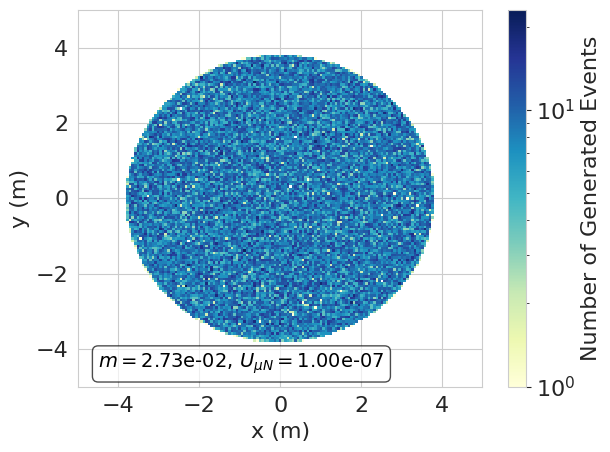

In [ ]:
i = 3
kwags = {}
kwags['m'] = m_sample[i]
kwags['U'] = U_sample[i]
path=f"OGTPC1_Dipole_M{kwags['m']:.2e}_mu{kwags['U']:.2e}_example.parquet"
if os.path.isfile('./output/'+path):
    print(path)
    data = awk.from_parquet("output/"+path)

Emax = 5
axis = 3
ylim_E = 1e6; ylim_C = 1e6
xrange = [-5,5]; yrange = [-5,5]; zrange = [-5,5]

plot_positions(data,zrange,yrange,"z","y",kwags=kwags,binnum=160,pot=POT['ND280_nu_2019'])
plot_positions(data,xrange,yrange,"x","y",kwags=kwags,binnum=160,pot=POT['ND280_nu_2019'])